In [12]:
# Gym stuff
import gymnasium as gym
import torch
import os
import sys
sys.path.append(os.path.abspath("..")) 
import gym_envs
print(torch.cuda.is_available())  # Should print True if GPU is available

# Stable baselines - rl stuff
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C, DDPG, DQN, SAC, TD3
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import seaborn as sns
import os

True


In [2]:
apple_df = pd.read_csv('../data/appldata.csv', parse_dates=["Date"], index_col="Date")
gamestop_df = pd.read_csv('../data/gmedata.csv', parse_dates=["Date"], index_col="Date")
google_df = pd.read_csv('../data/googldata.csv', parse_dates=["Date"], index_col="Date")

df = google_df
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000
2018-08-28,1255.900024,1256.560059,1242.969971,1245.859985,1245.859985,1366500
2018-08-29,1255.000000,1267.170044,1252.800049,1264.650024,1264.650024,1846300


In [3]:
# Create the environment setup
env = gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(10, 100), render_mode=None)
# It is to be noted that the first element of frame_bound should be greater than or equal to window_size.

capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 11990.565318652221
buy_hold_profit: 1990.5653186522213


In [4]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> Action space:", env.unwrapped.action_space)
print("> Observation space:", env.unwrapped.observation_space)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> buy_hold_profit:", env.unwrapped.buy_hold_profit)

env information:
> shape: (5, 2)
> Action space: Discrete(2)
> Observation space: Box(-10000000000.0, 10000000000.0, (5, 2), float32)
> df.shape: (2335, 6)
> prices.shape: (95,)
> signal_features.shape: (95, 2)
> buy_hold_profit: 11990.565318652221


In [5]:
# Print Stats
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):
    def __init__(self, check_freq: int = 100, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.progress_bar = None

    def _on_training_start(self) -> None:
        """
        Called at the start of training.
        Initializes the progress bar.
        """
        if self.verbose:
            self.progress_bar = tqdm(total=self.model._total_timesteps, desc="Training Progress")

    def _on_step(self) -> bool:
        """
        Updates the progress bar on each step.
        """
        if self.progress_bar is not None:
            self.progress_bar.update(1)
        return True

    def _on_training_end(self) -> None:
        """
        Closes the progress bar at the end of training.
        """
        if self.progress_bar is not None:
            self.progress_bar.close()


class RewardTrackerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0
        self.total_reward = 0

    def _on_step(self) -> bool:
        # Get rewards from the environment
        rewards = self.locals['rewards']
        self.total_reward += np.sum(rewards)

        # Check if an episode is done
        dones = self.locals['dones']
        for done in dones:
            if done:
                self.episode_rewards.append(self.total_reward)
                self.episode_lengths.append(self.episode_count)
                self.total_reward = 0
                self.episode_count += 1
        
        return True

In [21]:
# Train + Test the environment

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print ("seed :", SEED)

progress_callback = ProgressBarCallback(check_freq=100)
reward_callback = RewardTrackerCallback()

# Train vectorized environment
env_maker = lambda: gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(10, 1500))
env = DummyVecEnv([env_maker])
env.seed(SEED)
env.action_space.seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = PPO('MlpPolicy', env, learning_rate=0.0001, verbose=0, device=device)
#model = A2C('MlpPolicy', env, learning_rate=0.0001, verbose=0, device=device)
#model = DQN('MlpPolicy', env, learning_rate=0.0001, verbose=0, device=device)

model.learn(total_timesteps=100000, callback=[progress_callback, reward_callback])

# Print episode reward statistics
min_reward, avg_reward, max_reward = print_stats(reward_callback.episode_rewards)

# Define the directory to save the model
save_dir = "../models/"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

# Save the model with the new version number
#model.save(f"{save_dir}stock_model_beta")
model.save(f"{save_dir}stock_model_beta_v2")
print(f"Saved stock_model_beta_v2")

/home/shiven/Documents/GitHub/algo-trading/venv/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


seed : 42
capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 24682.542191648463
buy_hold_profit: 14682.542191648463


Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Training Progress: 100352it [01:03, 1572.61it/s]                           

Min. Reward          :   -481.188
Avg. Reward          :    201.020
Max. Reward          :    586.155
Saved stock_model_beta_v2


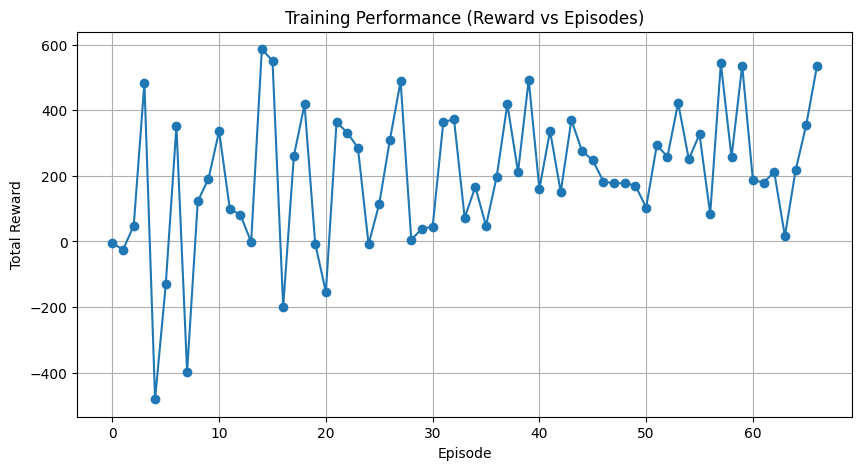

In [22]:
# Plot training rewards
plt.figure(figsize=(10, 5))
plt.plot(reward_callback.episode_lengths, reward_callback.episode_rewards, marker='o', linestyle='-')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance (Reward vs Episodes)")
plt.grid()
plt.show()

capital: 10000
trade_fee_percent: 0.0
buy_hold_end capital: 17070.589416474122
buy_hold_profit: 7070.589416474122
info: {'total_reward': 371.51404882812494, 'total_profit': 6604.168033008664, 'position': <Positions.Short: 0>}
Total reward: 371.51404882812494


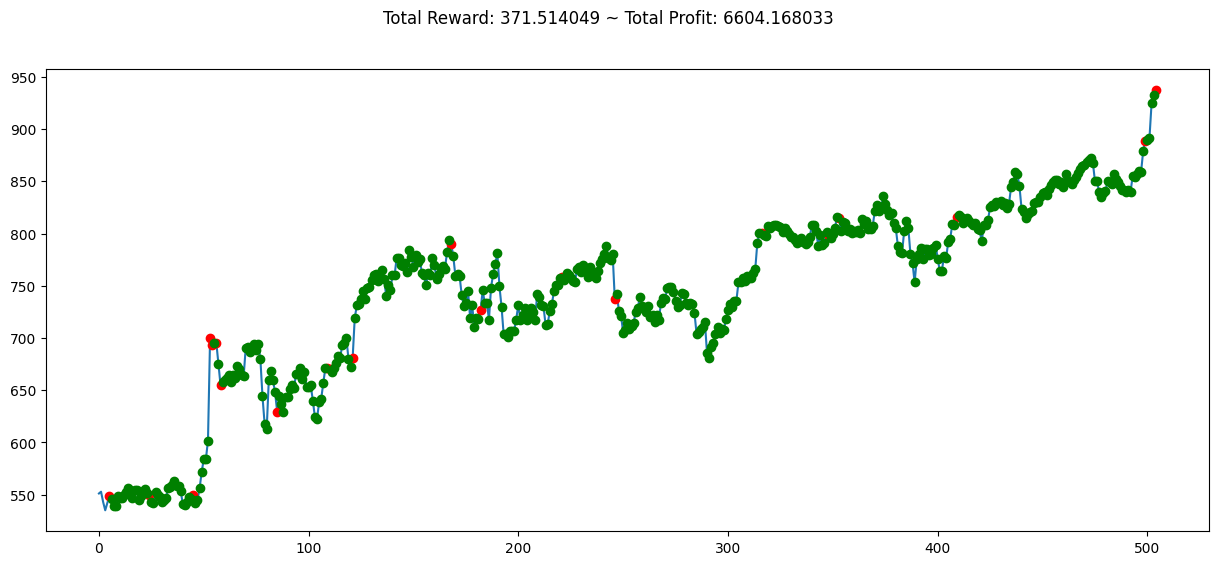

In [20]:
# Initialize the environment
env = gym.make('beta-stocks-v0', df=df, trade_fee_percent=0.0, capital=10000, window_size=5, frame_bound=(1500, 2000))
model = PPO.load("../models/stock_model_beta")  # Change to your saved model path

# Test the model
observation, info = env.reset(seed=SEED)  # Reset the environment
env.action_space.seed(SEED)

done = False
total_reward = 0

while not done:
    action, _states = model.predict(observation)  # Get action from the model
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward  # Accumulate the reward
    done = terminated or truncated  # Check if episode is done
    
    if done:
        print("info:", info)  # Output additional information when done
        break


print(f"Total reward: {total_reward}")
# Plot the results
plt.figure(figsize=(15, 6))
plt.cla()
# Ensure this method is correctly defined in your environment
env.unwrapped.render_all()  
plt.show()